17.1 On a dollar bar series on E-mini S&P 500 futures

(a) Apply the Brown-Durbin-Evans method. Does it recognize the dot-com
bubble? (현재 보유한 데이터가 해당 기간에 Volume이 존재하지 않아서 dollar bar가 생성 불가능해서 pass)

(b) Apply the Chu-Stinchcombe-White method. Does it find a bubble in 2007–2008?

찾을 수 있다. 2005~2006년에 비해서 확실히 2007~2008년이 비정상적인 가격흐름으로 인한 오차가 누적되는 현상이 두르러졌기 때문이다.

In [4]:
# Create Dollor Bars

import pandas as pd
import numpy as np
import sqlite3
from statsmodels.tsa.stattools import adfuller

data_path="../db/sp.db"
con=sqlite3.connect(data_path)
cur=con.cursor()
query='''SELECT * FROM sp WHERE "index" BETWEEN "2005-06-30" AND "2012-01-01"'''
data=pd.read_sql_query(query,con)
data.set_index("index",inplace=True)
data.index=pd.to_datetime(data.index, format='mixed')

def get_dollar_bar(df:pd.DataFrame, sampling_size:float)->pd.DataFrame:
    df["dollar"]=df["Close"]*df["Volume"]
    start_idx=0
    before_cum_dollar=0
    bar_list=[]
    for i in range(len(df)):
        if before_cum_dollar+df["dollar"].iloc[i]>=sampling_size:
            bar={
                'Close': df["Close"].iloc[i],
                'Volume': df['Volume'].iloc[start_idx:i+1].sum(),
            }
            bar_list.append((df.index[i], bar))
            start_idx=i+1
            before_cum_dollar=0
        else:
            before_cum_dollar+=df["dollar"].iloc[i]
    if before_cum_dollar>0:
        bar={
            'Close': df["Close"].iloc[-1],
            'Volume': df['Volume'].iloc[start_idx:].sum(),
        }
        bar_list.append((df.index[-1], bar))
    bar_df=pd.DataFrame.from_dict(dict(bar_list),orient="index")
    bar_df.index.name="index"
    bar_df.index=pd.to_datetime(bar_df.index)
    bar_df.sort_index(inplace=True)
    return bar_df

def get_volume_bar(df:pd.DataFrame, sampling_size:int)->pd.DataFrame:
    start_idx=0
    bar_list=[]
    volume_sum=0
    for i in range(len(df)):
        if volume_sum+df["Volume"].iloc[i]>=sampling_size:
            bar={
                'Close': df["Close"].iloc[i],
                'Volume': df['Volume'].iloc[start_idx:i+1].sum(),
            }
            bar_list.append((df.index[i], bar))
            start_idx=i+1
            volume_sum=0
        else:
            volume_sum+=df["Volume"].iloc[i]
    if start_idx<len(df):
        bar={
            'Close': df["Close"].iloc[-1],
            'Volume': df['Volume'].iloc[start_idx:].sum(),
        }
        bar_list.append((df.index[-1], bar))
    bar_df=pd.DataFrame.from_dict(dict(bar_list),orient="index")
    bar_df.index.name="index"
    bar_df.index=pd.to_datetime(bar_df.index)
    bar_df.sort_index(inplace=True)
    return bar_df

trading_days=len(np.unique(data.index.date))
total_volume=(data['Volume']*data['Close']).sum()
desired_bar_cnt=10
th=total_volume/(trading_days*desired_bar_cnt)


dollar_bar=get_dollar_bar(data, th)
result = adfuller(dollar_bar['Close'])
print(f"Dollar Threshold: {th}, ADF Statistic: {result[0]}, p-value: {result[1]}")



Dollar Threshold: 493329.338019851, ADF Statistic: -1.804898061920346, p-value: 0.3780326676743795


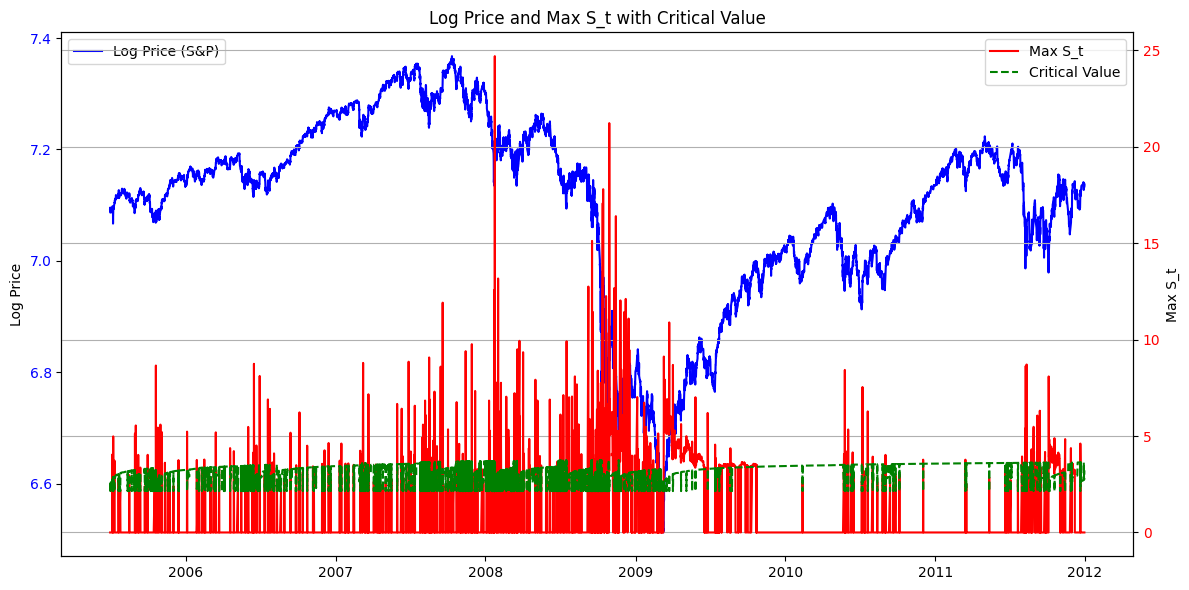

In [5]:
# Chu-Stinchcombe-White method
def get_max_s_t(log_price:pd.Series)->pd.Series:
    y=log_price.reset_index(drop=True) # index T-1: T번째 time을 의미
    T=len(y)

    s_dy=log_price.diff().dropna()**2
    s_dy_sum=s_dy.cumsum()
    div=np.arange(1, T)
    var=s_dy_sum/div
    var=pd.concat([pd.Series([np.nan], index=[log_price.index[0]]), var])
    sigma=np.sqrt(var) # index T-1: T번째 time을 의미
    max_s_t=pd.Series(np.nan, index=log_price.index)
    target_n_t=pd.Series(np.nan, index=log_price.index)
    for t in range(1, T): 
        # possible n<t
        n_vals=np.arange(t)
        if sigma.iloc[t] == 0:
            s_n_t=np.inf * np.ones(len(n_vals))
        else:
            s_n_t=(y.iloc[t]-y.iloc[n_vals])/(sigma.iloc[t]*np.sqrt(t-n_vals))
        max_s_t.iloc[t]=s_n_t.max()
        target_n_t.iloc[t]=n_vals[s_n_t.argmax()]
    return max_s_t, target_n_t

log_price = np.log(dollar_bar['Close'])
max_s_t, target_n_t = get_max_s_t(log_price)

# critial value
critical_value=np.sqrt(4.6+np.log(np.arange(len(target_n_t))-target_n_t))
max_s_t[max_s_t<critical_value]=0

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# log price
ax1.plot(log_price, label='Log Price (S&P)', color='blue')
ax1.set_ylabel('Log Price')
ax1.tick_params(axis='y', labelcolor='blue')

# max S_t
ax2= ax1.twinx()
ax2.plot(max_s_t.clip(0, 30), label='Max S_t', color='red')
ax2.set_ylabel('Max S_t')
ax2.tick_params(axis='y', labelcolor='red')
ax2.plot(critical_value, label='Critical Value', color='green', linestyle='--')
ax2.legend(loc='upper right')
ax1.legend(loc='upper left')
plt.title('Log Price and Max S_t with Critical Value')
plt.grid()
plt.tight_layout()
plt.show()

17.2 On adollar bar series on E-mini S&P 500 futures,

(a) Compute the SDFC (Chow-type) explosiveness test.  
What break date does this method select? Is this what you expected?  

$\delta>1$인 2007중순까지 explosive한 버블이 형성된 상태이고, 2008년 1월 이후부터 $\delta$가 0보다 작아지면서 침체기에 들어섰다. 이는 위의 테스트와 비슷하게 내가 기대한바와 같다.

18779it [04:48, 65.17it/s]


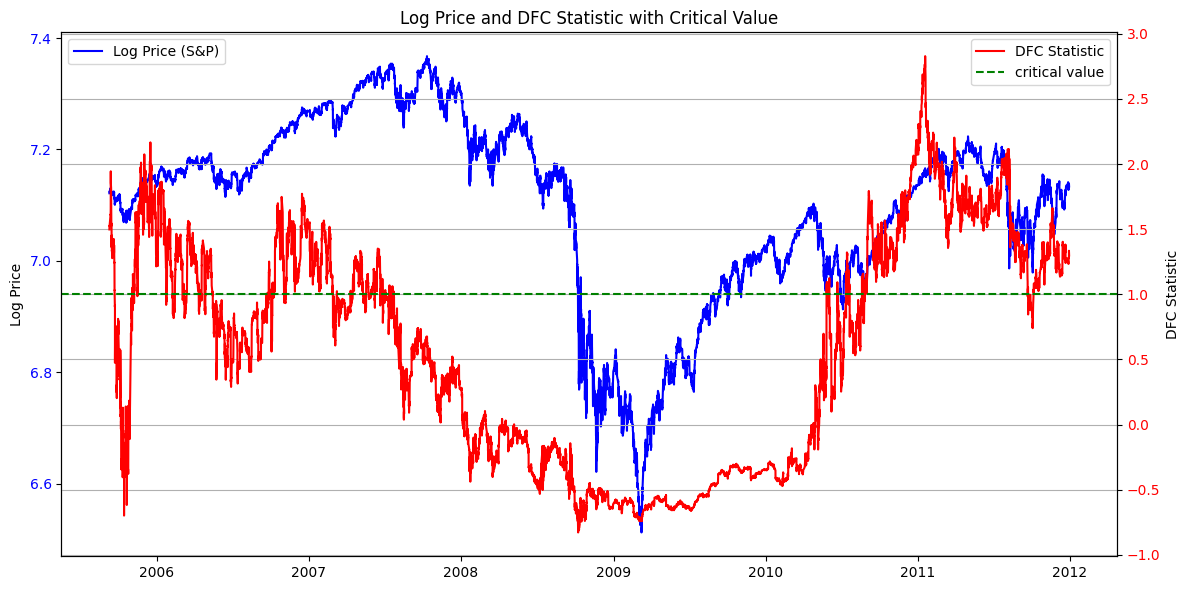

In [6]:
import statsmodels.api as sm
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def get_dfc_statistics(price:pd.Series, tau:float):
    dummy=pd.Series(1, index=price.index)
    dummy.iloc[:int(len(dummy)*tau)]=0
    dummy=dummy.iloc[1:]
    shifted_price=price.shift(1).dropna()
    diff_price=price.diff().dropna()
    X=shifted_price*dummy
    res=sm.OLS(diff_price, sm.add_constant(X)).fit()
    dfc_statistic=res.params.iloc[1]/res.bse.iloc[1]
    return dfc_statistic

tau0=0.15
step=0.05
min_sample_size=500
dfc_statistics=pd.Series(np.nan, index=log_price.index)

def get_sdfc_statistics(t:int, tau:float):
    price=log_price.iloc[:t+1]
    max_dfc_statistic=-np.inf
    for tau in np.arange(tau0, 1-tau0, step):
        dfc_statistic=get_dfc_statistics(price, tau)
        max_dfc_statistic=max(max_dfc_statistic, dfc_statistic)
    return max_dfc_statistic

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(get_sdfc_statistics, t, tau0): t for t in range(min_sample_size, len(log_price))}
    for i, future in tqdm(enumerate(futures)):
        result = future.result()
        dfc_statistics.iloc[i + min_sample_size] = result
    
dfc_statistics = dfc_statistics.dropna()


fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(log_price.loc[dfc_statistics.index], label='Log Price (S&P)', color='blue')
ax1.set_ylabel('Log Price')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(dfc_statistics, label='DFC Statistic', color='red')
ax2.set_ylabel('DFC Statistic')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=1, color='green', linestyle='--', label='critical value')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Log Price and DFC Statistic with Critical Value')
plt.grid()
plt.tight_layout()
plt.show()


(b) Compute and plot the SADF values for this series.Do you observe extreme
spikes around the dot-combubble and before the Great Recession? Did the
bursts also cause spikes?

침체기의 경우 지나친 하락에 선행하기 보다는 오히려 동행하거나 후행하여 현재가 침체상태인지 보여준다. 현재표상 완만한 상승기에는 미묘한 signal이 존재하며 spike는 존재하지 않는다.

18279it [1:22:44,  3.68it/s]


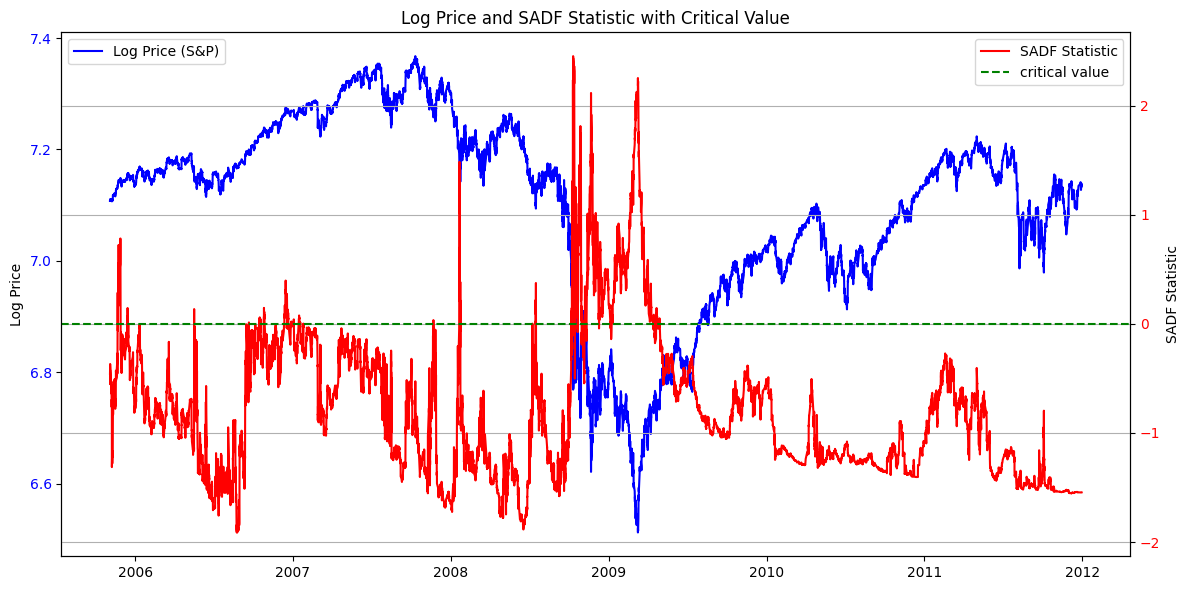

In [7]:
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

min_sampling_size=1000
segment_size=10
adf_statistics_df=pd.DataFrame(index=log_price.index[min_sampling_size:], columns=np.arange(segment_size))
def adf_statistics(t):
    price=log_price.iloc[:t+1]
    segment_length=len(price) // segment_size
    adf_statistics = []
    for i in range(segment_size):
        start_idx = i * segment_length
        adf_result = adfuller(price.iloc[start_idx:])
        adf_statistics.append(adf_result[0])
    return pd.Series(adf_statistics, index=adf_statistics_df.columns)

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(adf_statistics, t) for t in range(min_sampling_size, len(log_price))]
    for i, future in tqdm(enumerate(futures)):
        adf_statistics_df.iloc[i] = future.result()
    

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(log_price.loc[adf_statistics_df.index], label='Log Price (S&P)', color='blue')
ax1.set_ylabel('Log Price')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(adf_statistics_df.max(axis=1), label='SADF Statistic', color='red')
ax2.set_ylabel('SADF Statistic')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=0, color='green', linestyle='--', label='critical value')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Log Price and SADF Statistic with Critical Value')
plt.grid()
plt.tight_layout()
plt.show()
        

17.3 Following on exercise 2,

(a) Determine the periods where the series exhibited
(i) Steady conditions
(ii) Unit-Root conditions
(iii) Explosive conditions

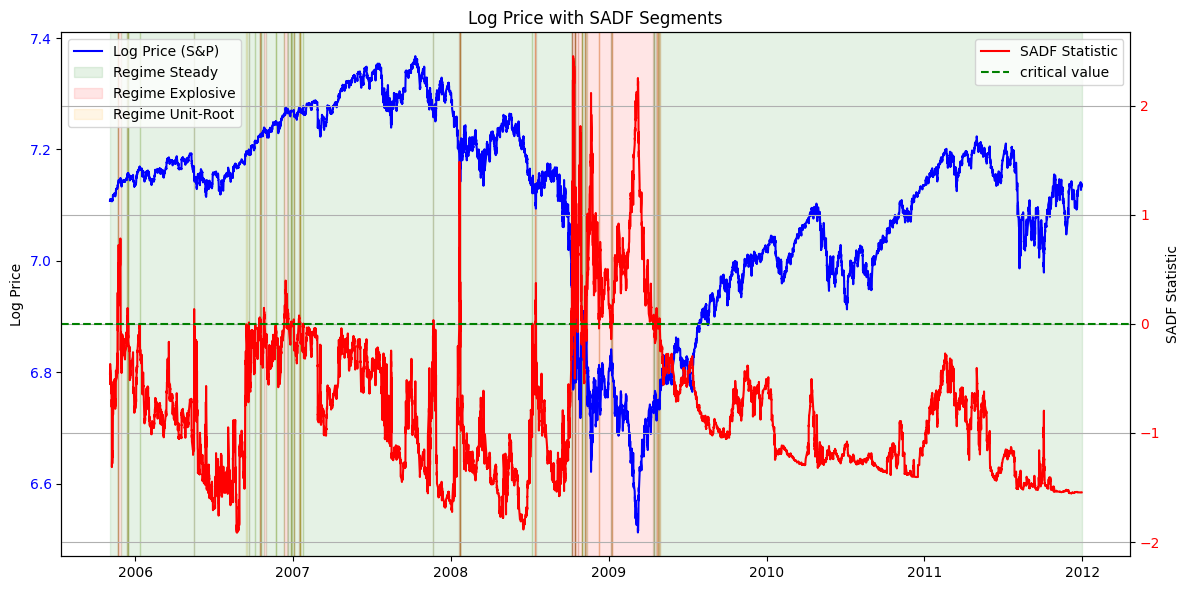

In [8]:
sadf_statistics= adf_statistics_df.max(axis=1)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(log_price.loc[sadf_statistics.index], label='Log Price (S&P)', color='blue')
ax1.set_ylabel('Log Price')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(sadf_statistics, label='SADF Statistic', color='red')
ax2.set_ylabel('SADF Statistic')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=0, color='green', linestyle='--', label='critical value')
epsilon=1e-2
regime_series= pd.Series(1, index=sadf_statistics.index)
regime_series[sadf_statistics < -epsilon] = 0
regime_series[sadf_statistics >= epsilon] = 2

def get_regime_intervals(regime_series:pd.Series):
    intervals=[]
    current_val=None
    start_idx=None

    for t, val in regime_series.items():
        if current_val is None:
            current_val = val
            start_idx = t
        elif val != current_val:
            intervals.append((start_idx, t, current_val))
            current_val = val
            start_idx = t

    if current_val is not None:
        intervals.append((start_idx, t, current_val))
    return intervals

color_map = {0: 'green', 1: 'orange', 2: 'red'}
regime_name= {0: 'Steady', 1: 'Unit-Root', 2: 'Explosive'}
is_labeled={0: False, 1: False, 2: False}
for start, end, regime in get_regime_intervals(regime_series):
    if not is_labeled[regime]:
        is_labeled[regime] = True
        ax1.axvspan(start, end, color=color_map[regime], alpha=0.1, label=f'Regime {regime_name[regime]}')
    else:
        ax1.axvspan(start, end, color=color_map[regime], alpha=0.1)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Log Price with SADF Segments')
plt.grid()
plt.tight_layout()
plt.show()

(b) Compute QADF

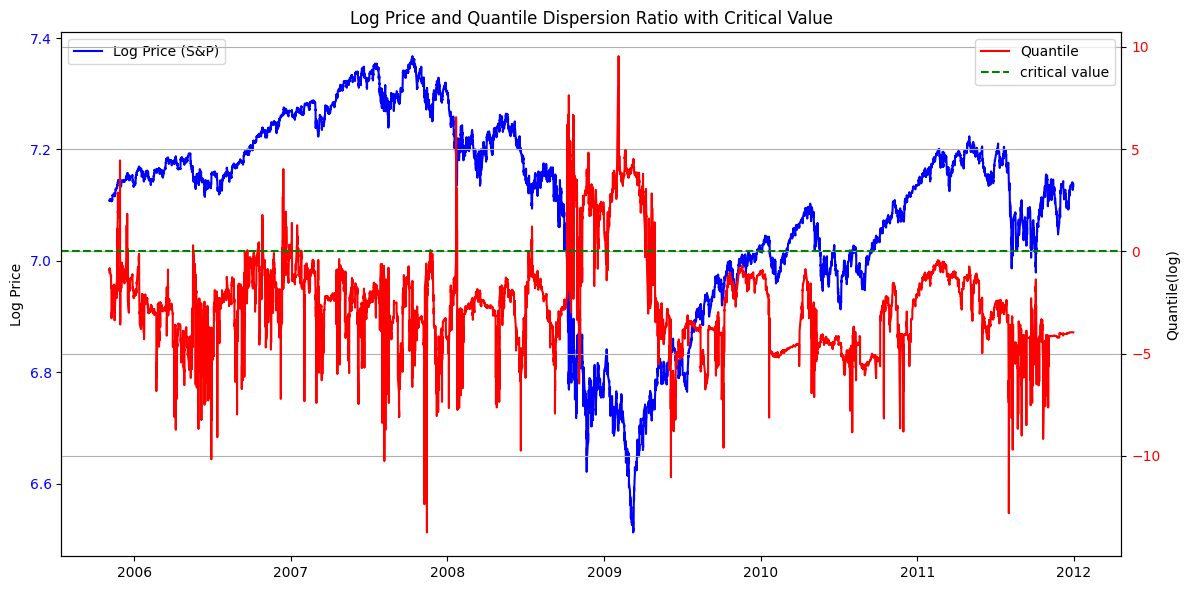

In [25]:
q=0.95
v=0.025
value_columns= pd.to_numeric(adf_statistics_df.columns, errors='coerce').notna()
value_columns = adf_statistics_df.columns[value_columns]
adf_statistics_df['quantile']=adf_statistics_df[value_columns].quantile(q=q, axis=1)
adf_statistics_df['quantive_dispersion']=adf_statistics_df[value_columns].quantile(q=q+v, axis=1) - adf_statistics_df[value_columns].quantile(q=q-v, axis=1)
adf_statistics_df['quantile_dispersion_ratio'] = adf_statistics_df['quantile'] / adf_statistics_df['quantive_dispersion']
adf_statistics_df['quantile_dispersion_ratio']= adf_statistics_df['quantile_dispersion_ratio'].astype(float)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(log_price.loc[adf_statistics_df.index], label='Log Price (S&P)', color='blue')
ax1.set_ylabel('Log Price')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(np.sign(adf_statistics_df['quantile_dispersion_ratio'])*np.log(adf_statistics_df['quantile_dispersion_ratio'].abs()), label='Quantile', color='red')
ax2.set_ylabel('Quantile(log)')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=0, color='green', linestyle='--', label='critical value')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Log Price and Quantile Dispersion Ratio with Critical Value')
plt.grid()
plt.tight_layout()
plt.show()

(c) Compute CADF

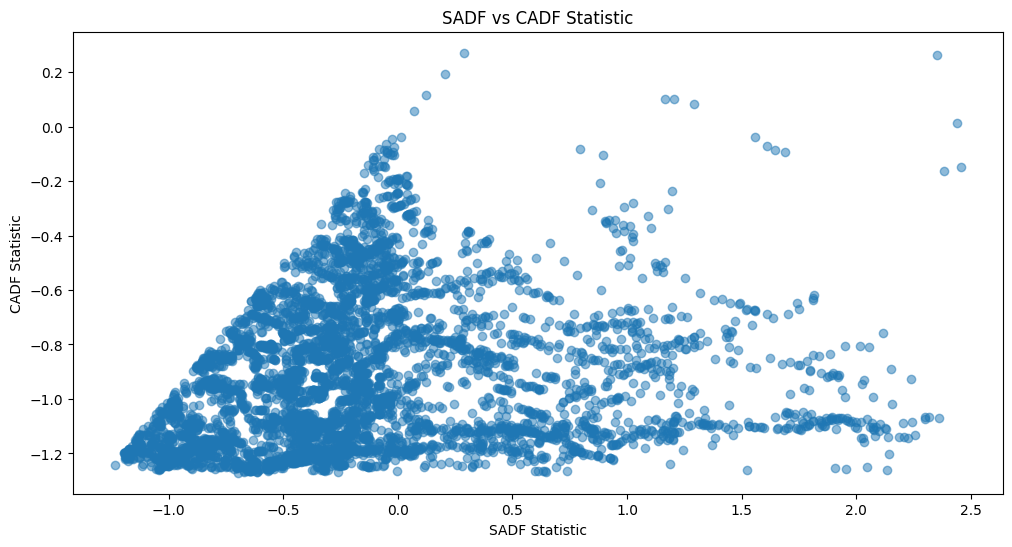

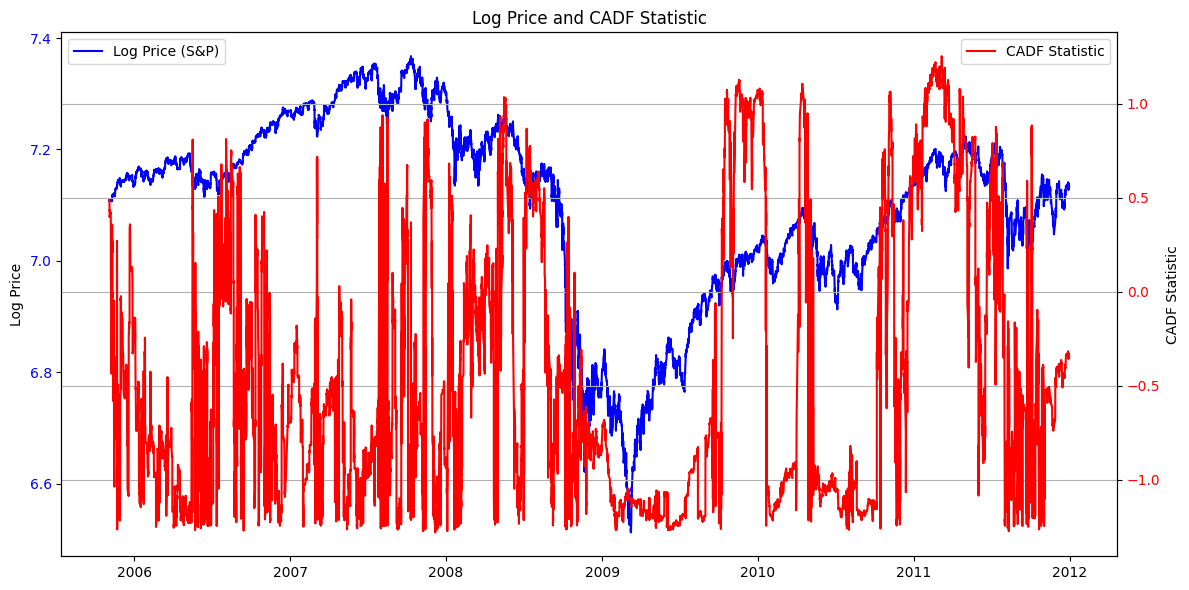

In [10]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad
value_columns= pd.to_numeric(adf_statistics_df.columns, errors='coerce').notna()
value_columns = adf_statistics_df.columns[value_columns]
adf_statistics_df['pdf']=[gaussian_kde(adf_statistics_df.loc[i, value_columns].values.astype(float)) for i in adf_statistics_df.index]
def get_cdf(pdf, x):
    return quad(pdf, x, np.inf)[0]
def get_mean(pdf, x):
    return quad(lambda t: t * pdf(t), x, np.inf)[0]
def get_var(pdf, x, r):
    mean = get_mean(pdf, x)/r
    return quad(lambda t: (t - mean) ** 2 * pdf(t), x, np.inf)[0]
cdf_vec= np.vectorize(get_cdf)
mean_vec= np.vectorize(get_mean)
var_vec= np.vectorize(get_var)
adf_statistics_df['r']=cdf_vec(adf_statistics_df['pdf'], adf_statistics_df['quantile'])
adf_statistics_df['c_mean']=mean_vec(adf_statistics_df['pdf'], adf_statistics_df['quantile'])/ adf_statistics_df['r']
adf_statistics_df['c_var']=var_vec(adf_statistics_df['pdf'], adf_statistics_df['quantile'], adf_statistics_df['r'])/ adf_statistics_df['r']
adf_statistics_df['sadf_statistic']= adf_statistics_df[value_columns].max(axis=1)
adf_statistics_df['cadf_statistic']= (adf_statistics_df['sadf_statistic'] - adf_statistics_df['c_mean'])/ np.sqrt(adf_statistics_df['c_var'])


fig= plt.subplots(figsize=(12, 6))
plot_idx=adf_statistics_df[adf_statistics_df['cadf_statistic']<adf_statistics_df['sadf_statistic']].index
plt.scatter(adf_statistics_df['sadf_statistic'].loc[plot_idx], adf_statistics_df['cadf_statistic'].loc[plot_idx], alpha=0.5)
plt.title('SADF vs CADF Statistic')
plt.xlabel('SADF Statistic')
plt.ylabel('CADF Statistic')
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(log_price.loc[adf_statistics_df.index], label='Log Price (S&P)', color='blue')
ax1.set_ylabel('Log Price')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(adf_statistics_df['cadf_statistic'], label='CADF Statistic', color='red')
ax2.set_ylabel('CADF Statistic')
ax2.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Log Price and CADF Statistic')
plt.grid()
plt.tight_layout()
plt.show()



17.4 On a dollar bar series on E-mini S&P 500 futures,

(a) Compute SMT for SM-Poly1 and SM-Poly 2, where 𝜑 = 1. What is their
correlation?

In [11]:
min_sample_size=1000
segment_size=10
mt_ploy1=pd.DataFrame(index=log_price.index[min_sample_size:], columns=np.arange(segment_size))
mt_ploy2=pd.DataFrame(index=log_price.index[min_sample_size:], columns=np.arange(segment_size))
mt_exp=pd.DataFrame(index=log_price.index[min_sample_size:], columns=np.arange(segment_size))
mt_time_diff=pd.DataFrame(index=log_price.index[min_sample_size:], columns=np.arange(segment_size))

def get_mt_statistics(t):
    price=dollar_bar['Close'].iloc[:t+1]
    l_price=log_price.iloc[:t+1]
    segment_length=len(price) // segment_size
    sm_ploy1_statistics = []
    sm_ploy2_statistics = []
    sm_exp_statistics = []
    sm_time_diff_list=[]
    for i in range(segment_size):
        start_idx = i * segment_length
        T=len(price.iloc[start_idx:])
        p1, v1=np.polyfit(np.arange(T), price.iloc[start_idx:], 2, cov=True)
        p2, v2=np.polyfit(np.arange(T), l_price.iloc[start_idx:], 2, cov=True)
        p3, v3=np.polyfit(np.arange(T), l_price.iloc[start_idx:], 1, cov=True)
        sm_ploy1_statistics.append(p1[0]/np.sqrt(v1[0, 0]))
        sm_ploy2_statistics.append(p2[0]/np.sqrt(v2[0, 0]))
        sm_exp_statistics.append(p3[0]/np.sqrt(v3[0, 0]))
        sm_time_diff_list.append(T-1)
    return sm_ploy1_statistics, sm_ploy2_statistics, sm_exp_statistics, sm_time_diff_list

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(get_mt_statistics, t) for t in range(min_sample_size, len(log_price))]
    for t, future in tqdm(enumerate(futures)):
        sm_ploy1_statistics, sm_ploy2_statistics, sm_exp_statistics, sm_time_diff_list = future.result()
        mt_ploy1.iloc[t-min_sample_size] = sm_ploy1_statistics
        mt_ploy2.iloc[t-min_sample_size] = sm_ploy2_statistics
        mt_exp.iloc[t-min_sample_size] = sm_exp_statistics
        mt_time_diff.iloc[t-min_sample_size] = sm_time_diff_list

plt.show()

18279it [03:13, 94.59it/s] 


Correlation between polynomial 1 and polynomial 2: 0.9974442409341159


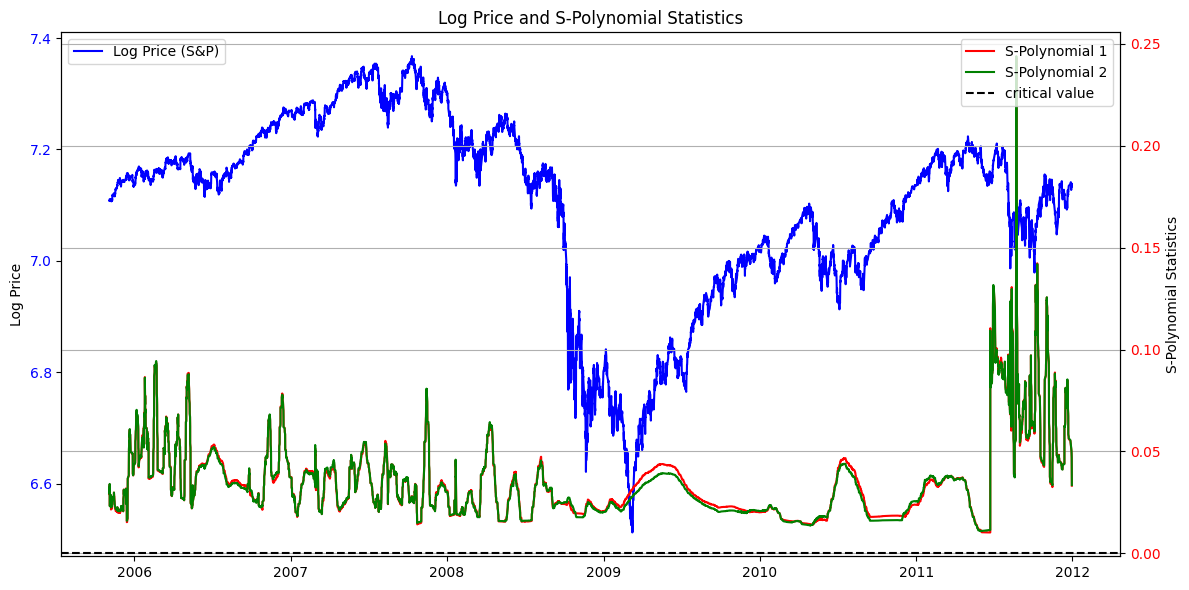

In [12]:
smt_ploy1=(abs(mt_ploy1)/mt_time_diff).max(axis=1)
smt_ploy2=(abs(mt_ploy2)/mt_time_diff).max(axis=1)
corr= smt_ploy1.corr(smt_ploy2)
print(f"Correlation between polynomial 1 and polynomial 2: {corr}")

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(log_price.loc[smt_ploy1.index], label='Log Price (S&P)', color='blue')
ax1.set_ylabel('Log Price')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()       
ax2.plot(smt_ploy1, label='S-Polynomial 1', color='red')
ax2.plot(smt_ploy2, label='S-Polynomial 2', color='green')
ax2.set_ylabel('S-Polynomial Statistics')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=0, color='black', linestyle='--', label='critical value')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Log Price and S-Polynomial Statistics')
plt.grid()
plt.tight_layout()
plt.show()

(b) Compute SMT for SM-Exp,where 𝜑 = 1 and 𝜑 = 0.5.What is their correlation?

Correlation between exponential phi1 and phis: 0.37145076425944334


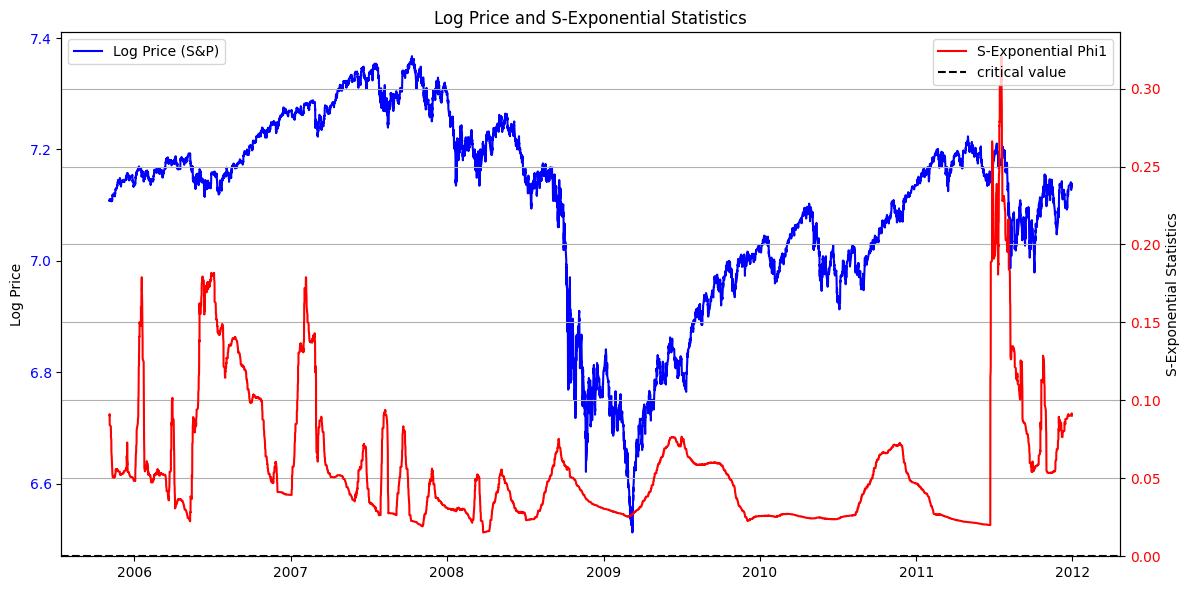

In [13]:
smt_exp_phi1=(abs(mt_exp/mt_time_diff)).max(axis=1)
smt_exp_phis=(abs(mt_exp/(mt_time_diff**0.5))).min(axis=1)
cor=smt_exp_phi1.corr(smt_exp_phis)
print(f"Correlation between exponential phi1 and phis: {cor}")

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(log_price.loc[smt_exp_phi1.index], label='Log Price (S&P)', color='blue')
ax1.set_ylabel('Log Price')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()   
ax2.plot(smt_exp_phi1, label='S-Exponential Phi1', color='red')
#ax2.plot(smt_exp_phis, label='S-Exponential Phis', color='green')
ax2.set_ylabel('S-Exponential Statistics')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=0, color='black', linestyle='--', label='critical value')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Log Price and S-Exponential Statistics')
plt.grid()
plt.tight_layout()
plt.show()

17.5 If you compute the reciprocal of each price, the series ${y_t^{-1}}$ turns bubbles into
bursts and bursts into bubbles.

(a) Is this transformation needed, to identify bursts?

아래와 같이 바꿨을때 DFC 테스트상으로 $\delta>1$인 상황에서 가격이 붕괴하기 시작하므로 burst를 판단할 수 있다.

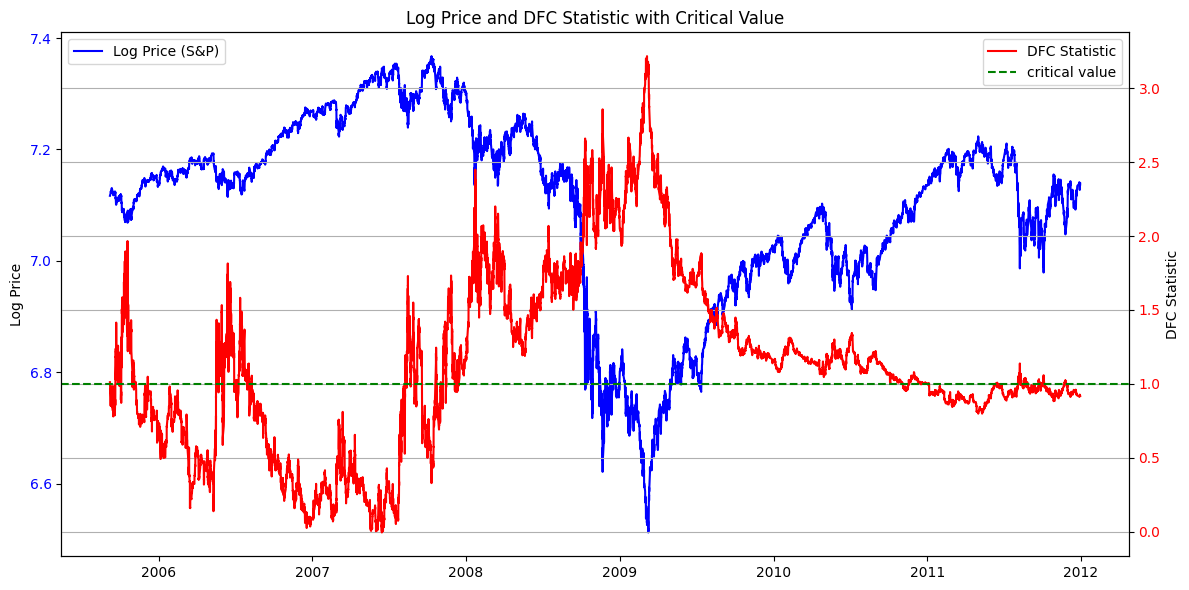

In [14]:
import statsmodels.api as sm

def get_dfc_statistics(price:pd.Series, tau:float):
    dummy=pd.Series(1, index=price.index)
    dummy.iloc[:int(len(dummy)*tau)]=0
    dummy=dummy.iloc[1:]
    shifted_price=-price.shift(1).dropna()
    diff_price=price.diff().dropna()
    X=shifted_price*dummy
    res=sm.OLS(diff_price, sm.add_constant(X)).fit()
    dfc_statistic=res.params.iloc[1]/res.bse.iloc[1]
    return dfc_statistic

tau0=0.15
step=0.05
min_sample_size=500
dfc_statistics=pd.Series(np.nan, index=log_price.index)
for t in range(min_sample_size, len(log_price)):
    price=log_price.iloc[:t]
    max_dfc_statistic=-np.inf
    for tau in np.arange(tau0, 1-tau0, step):
        dfc_statistic=get_dfc_statistics(price, tau)
        max_dfc_statistic=max(max_dfc_statistic, dfc_statistic)
    dfc_statistics.iloc[len(price)-1]=max_dfc_statistic
dfc_statistics = dfc_statistics.dropna()


fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(log_price.loc[dfc_statistics.index], label='Log Price (S&P)', color='blue')
ax1.set_ylabel('Log Price')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(dfc_statistics, label='DFC Statistic', color='red')
ax2.set_ylabel('DFC Statistic')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=1, color='green', linestyle='--', label='critical value')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Log Price and DFC Statistic with Critical Value')
plt.grid()
plt.tight_layout()
plt.show()


(b) What methods in this chapter can identify bursts without requiring this
transformation?

Chu-Stinchcombe-White method를 쓰면 burst시에 값이 높게 나오므로 해당 방법을 쓰면 transformation 없이 구할 수 있다.